# Data processing and sampling with tensorflow data input pipelines 

The aim of this tutorial is to learn how to:
- read 3D images in nifiti format for training a neural network
- use tensorflow Dataset for efficient sampling of mini batches and on the fly data augmentation

This tutorial uses simulated PET/MR data and a network that has two input channels and one output channel. However, the basic concept of using a tensor data input pipeline generalizes easily to other examples using different data, different dimensions, or a different number of channels.

This tutorial is inspired by  this keras tutorial https://keras.io/examples/vision/3D_image_classification/ on 3D CT image classifiction, which is also highly recommended.

## Background

Efficient data sampling and data augmentation are crucial when training convolutional neural networks (CNN) - especially when using 3D images. Tensorflow offers tf.data.Dataset class which allows to do that in very elegant and efficient way. In the following we will read a few simulated PET and MR data sets that can be used to train a CNN for structure guided denoising and deconvolution of PET images. 

In [1]:
# import all the modules that we need for this tutorial

import tensorflow as tf
import nibabel as nib
import numpy as np
import pathlib

Make sure that the simulated brainweb PET/MR data sets were downloaded and that the main data path in the cell below is correct. Let's first find all data directories

In [2]:
# directory containing the simulated brain web data sets
data_dir = pathlib.Path('../data/training_data/brainweb/export')
batch_size = 10

# get all the subjects paths
subject_paths = list(data_dir.glob('subject??'))

Each simulated data set contains a low resolution and noisy standard OSEM PET reconstruction, a high resolution and low noist T1 MR, and a high resolution and low noise target reconstruction. All images volumes are saved in nifti format. Let's define a first helper function that uses nibabel to load a 3D nifti volume in defined orientation (LPS). The standard orientation of nifti is RAW which is why we have to flip the 0 and 1 axis.

In [3]:
def load_nii_in_lps(fname):
  """ function that loads nifti file and returns the volume and affine in 
      LPS orientation
  """
  nii = nib.load(fname)
  nii = nib.as_closest_canonical(nii)
  vol = np.flip(nii.get_fdata(), (0,1))

  return vol, nii.affine

Let's define another helper function that loads all 3 nifiti volumes of a data set and that also already performs an intensity normalization. For the latter, we divide both PET images by the 99.99 percentile of the OSEM volume, and the T1 MR by its 99.99 percentile. We could also divide by the maximum value, but the 99.99 percentile is more robust when working with noisy images.

In [4]:
def load_data_set(subject_path, sim = 0, counts = 1e7):

  # get the subject number from the path
  data_id = int(subject_path.parts[-1][-2:])

  # setup the file names
  mr_file   = pathlib.Path(subject_path) / 't1.nii.gz'
  osem_file = pathlib.Path(subject_path) / f'sim_{sim}' / f'osem_psf_counts_{counts:0.1E}.nii.gz'
  target_file = pathlib.Path(subject_path) / f'sim_{sim}' / 'true_pet.nii.gz'

  # load nifti files in RAS orientation
  mr, mr_aff = load_nii_in_lps(mr_file)
  osem, osem_aff = load_nii_in_lps(osem_file)
  target, target_aff = load_nii_in_lps(target_file)

  # normalize the intensities of the MR and PET volumes
  mr_scale   = np.percentile(mr, 99.99)
  osem_scale = np.percentile(osem, 99.99)

  mr     /= mr_scale
  osem   /= osem_scale
  target /= osem_scale

  return osem, mr, target, osem_scale, mr_scale

Now let's loop over all data directories and let's store all images in 2 big numpy arrays. The first array ```x_train``` should contain the input and the second array ```y_train``` the target for our CNN during training. When working with 3D volumes, the shape of the input and output to the CNN has to be ```(nbatch,n0,n1,n2,nchannels)``` where ```nbatch``` is the mini batch length, ```n0,n1,n2``` are the spatial dimentions, and ```nchannels``` are the number of input channels. In this example, we have two input channels (OSEM PET and T1 MR) and one output channel (target PET image).

In [5]:
osem_vols   = []
t1_vols     = []
target_vols = []

# load all the data sets
for subject_path in subject_paths:
  print(f'loading {subject_path}')

  data = load_data_set(subject_path, sim = 0, counts = 1e7)

  osem_vols.append(data[0])
  t1_vols.append(data[1])
  target_vols.append(data[2])

osem_vols   = np.array(osem_vols)
t1_vols     = np.array(t1_vols)
target_vols = np.array(target_vols)

x_train = np.stack((osem_vols,t1_vols), axis = -1)
y_train = np.expand_dims(target_vols, -1)

loading ../data/training_data/brainweb/export/subject04
loading ../data/training_data/brainweb/export/subject05
loading ../data/training_data/brainweb/export/subject06
loading ../data/training_data/brainweb/export/subject18
loading ../data/training_data/brainweb/export/subject20
loading ../data/training_data/brainweb/export/subject38
loading ../data/training_data/brainweb/export/subject41
loading ../data/training_data/brainweb/export/subject42
loading ../data/training_data/brainweb/export/subject43
loading ../data/training_data/brainweb/export/subject44
loading ../data/training_data/brainweb/export/subject45
loading ../data/training_data/brainweb/export/subject46


In many CNN training scenarios, on-the-fly data augmentation (e.g. cropping, rotating, change of contrast) is very usefule. Moreover, when working with 3D data sets, networks are often trained on smaller patches due to memory limitations on the available GPUs. Hence, we define a function samples a random 3D patch from the entire input and target data sets. The function simply uses random number to determine the center of a smaller path with size ```(s0,s1,s2)```. Moreover, we define margins along all directions ```m0,m1,m2``` to avoid sampling of small empty patches. 

In [6]:
def train_augmentation(x, y, s0 = 64, s1 = 64, s2 = 64, m0 = (40,40), m1 = (40,40), m2 = (40,40)):
  """data augmentation function for training """

  # extract a random sub volume
  sh0 = tf.cast(tf.math.ceil(s0/2), tf.int32)
  sh1 = tf.cast(tf.math.ceil(s1/2), tf.int32)
  sh2 = tf.cast(tf.math.ceil(s2/2), tf.int32)

  lm0 = tf.math.maximum(sh0, m0[0])
  rm0 = tf.math.maximum(sh0, m0[1])

  lm1 = tf.math.maximum(sh1, m1[0])
  rm1 = tf.math.maximum(sh1, m1[1])

  lm2 = tf.math.maximum(sh2, m2[0])
  rm2 = tf.math.maximum(sh2, m2[1])

  i0 = tf.random.uniform((), minval=lm0, maxval=x.shape[0]-rm0, dtype=tf.dtypes.int32) - sh0
  i1 = tf.random.uniform((), minval=lm1, maxval=x.shape[1]-rm1, dtype=tf.dtypes.int32) - sh1
  i2 = tf.random.uniform((), minval=lm2, maxval=x.shape[2]-rm2, dtype=tf.dtypes.int32) - sh2

  x_crop = tf.slice(x, begin = [i0,i1,i2,0], size = [s0,s1,s2,2])
  y_crop = tf.slice(y, begin = [i0,i1,i2,0], size = [s0,s1,s2,1])

  return x_crop, y_crop

Let's create a tensorflow data set from our numpy arrays stored in the host memory ```x_train, y_train```. Moreover, we use the ```shuffle``` and ```map``` methods to shuffle the data and to apply our defined data augmentation function on the fly. More information on the tensorflow dataset class can be found here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [7]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_loader.shuffle(len(x_train)).map(lambda x,y: train_augmentation(x,y, s0 = 129, s1 = 129, s2 = 129)).batch(batch_size).prefetch(2)

Finally, let's draw a mini-batch and let's visualize the first 4 3D data sets in the mini batch.

In [8]:
x_batch, y_batch = list(train_dataset.take(1))[0]

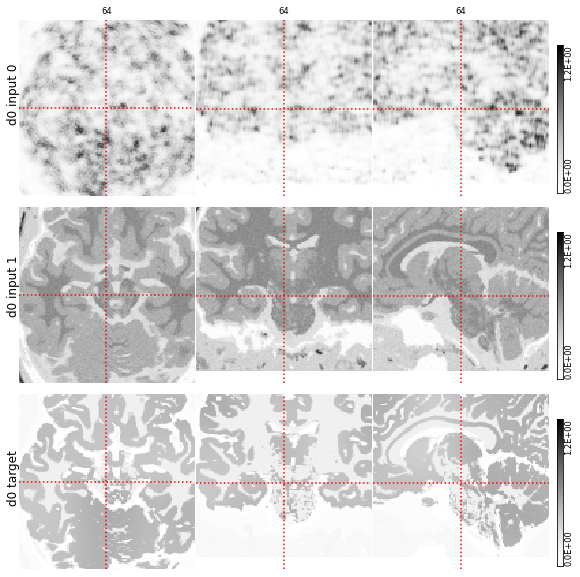

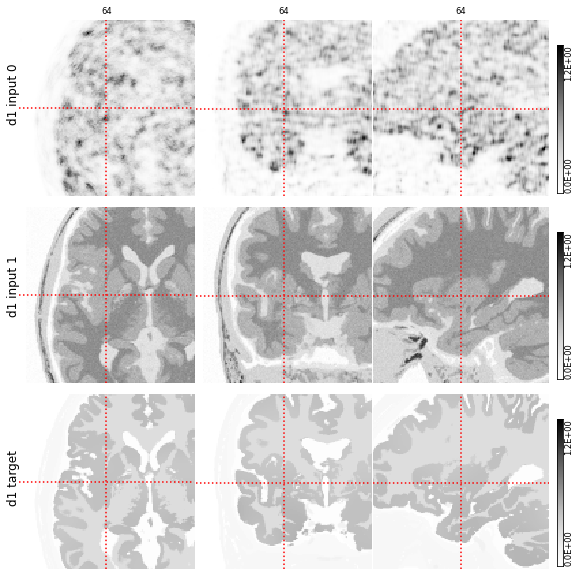

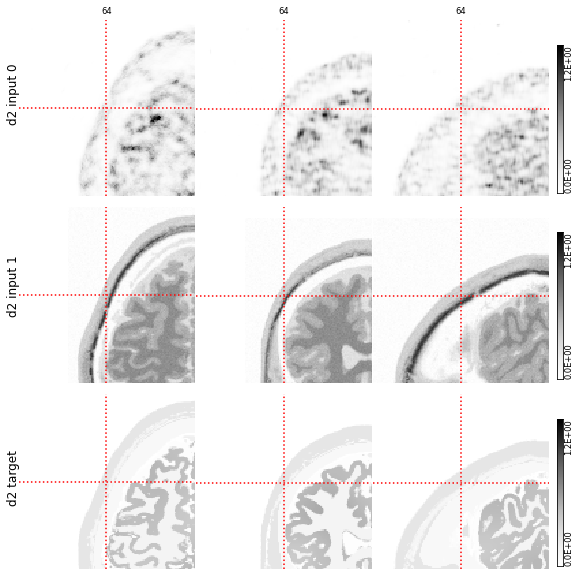

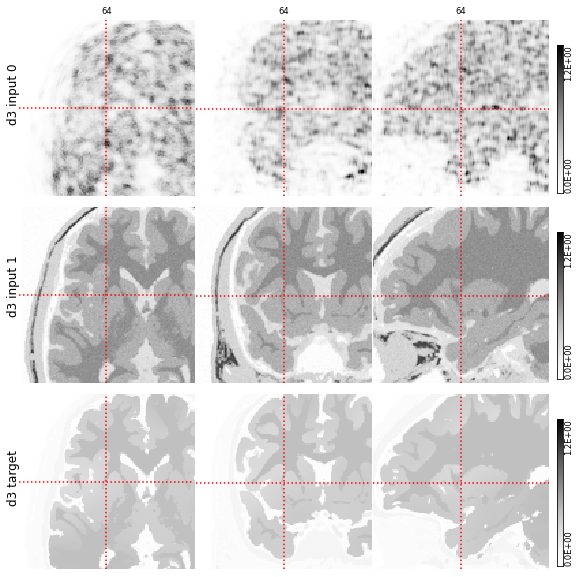

In [13]:
import pymirc.viewer as pv
for i in range(4):
  vi = pv.ThreeAxisViewer([x_batch[i,...,0].numpy().squeeze(), x_batch[i,...,1].numpy().squeeze(), 
                           y_batch[i,...,0].numpy().squeeze()],
                           imshow_kwargs = {'vmin':0,'vmax':1.2}, rowlabels = [f'd{i} input 0', f'd{i} input 1', f'd{i} target'])

## Your turn - recommended exercises
Now it is your turn, to familiarize yourself with the tensorflow dataset input pipeline:
1. modify ```train_data``` to get different spatial dimensions (e.g. 65,65,65)
2. write your own on-the-fly data augmentation function that: 
   - randomly inverts the contrast of the input MR image
   - randomly rotates the input and target images